# CNN to detect Lung Disease

## Table of Contents
1. Import Packages and Data
    * Packages used in project
    * Data for project
2. Data Visualization and Preprocessing
    * Visualize Data Images
    * Preprocess
    * Create Augmented Data
3. Train the Model
    * Create CNN
    * Optimize
    * Fit to Model
4. Analyze the Model
    * Accuracy
    * Precision and Recall
    * Confusion Matrix
5. Summary

In [76]:
# import packages 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os

In [57]:
# set up to import data 
root_dir = os.path.dirname(os.path.abspath('data'))
train_data_dir = os.path.join(root_dir,'data\\chest_xray\\train')
test_data_dir = os.path.join(root_dir,'data\\chest_xray\\test')
val_data_dir = os.path.join(root_dir,'data\\chest_xray\\val')

# data loading function updated kaggle
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [58]:
#import data
train = get_data(train_data_dir)
test = get_data(test_data_dir)
val = get_data(val_data_dir)

## Data Visualization and Preprocessing

In [59]:
# assign labels to data
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")

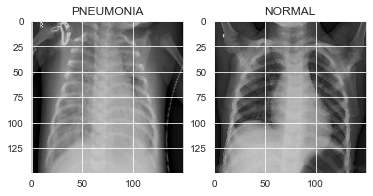

In [65]:
# view data images of each label type
fig, subplots = plt.subplots(1,2)
# Pnemonia data
subplots[0].imshow(train[0][0], cmap='gray')
subplots[0].set_title(labels[train[0][1]])
# Normal data
subplots[1].imshow(train[-1][0], cmap='gray')
subplots[1].set_title(labels[train[-1][1]]);

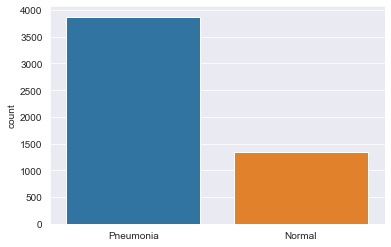

In [66]:
# look at datatypes
sns.set_style('darkgrid')
sns.countplot(l);

The images appear as expected for each type, however, there is an imbalance in the data since there are many more cases of Pneumonia than Normal.  Data augmentation can be used to increase the number of Normal training examples.  

In [67]:
# prepare the data structure
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [68]:
# perform normalization to prevent effects of grayscale variance from image quality
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [69]:
# resize the data for CNN 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [71]:
# create augmented data to take care of data imbalance and prevent overfitting
# augmentation methods: rotate data, zoom in on data, shift horizontally 
# or vertically, horizontally flip data
datagen = ImageDataGenerator(
        featurewise_center=False,                # don't set input mean to 0 over the dataset
        samplewise_center=False,                 # don't set each sample mean to 0
        featurewise_std_normalization=False,     # do not divide inputs by std of the dataset bc we have done this
        samplewise_std_normalization=False,      # do divide each input by its std bc we have done this
        zca_whitening=False,                     # do not apply ZCA whitening since we have normalized
        rotation_range = 15,                     # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15,                       # Randomly zoom image 15%
        width_shift_range=0.15,                  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,                 # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,                  # randomly horizontal flip images
        vertical_flip=False)                     # do not randomly vertical flip images

datagen.fit(x_train)

## Train the Model

In [74]:
# initialize model
model = Sequential()
# add layers
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
# compile model
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

# get summary of model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)       

In [90]:
# optimize until metric has stopped improving, then reduce learning rate 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, 
                                            verbose=1,factor=0.3, min_lr=0.001)

In [ ]:
# find the best model
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32), epochs = 6,
                    validation_data = datagen.flow(x_val, y_val), 
                    callbacks = [learning_rate_reduction])

Epoch 1/6
163/163 [==============================] - 302s 2s/step - loss: 0.1369 - accuracy: 0.9561 - val_loss: 1.0602 - val_accuracy: 0.5625
Epoch 2/6
163/163 [==============================] - 302s 2s/step - loss: 0.1340 - accuracy: 0.9613 - val_loss: 0.6726 - val_accuracy: 0.6250
Epoch 3/6
163/163 [==============================] - 310s 2s/step - loss: 0.1188 - accuracy: 0.9632 - val_loss: 9.4848 - val_accuracy: 0.5000
Epoch 4/6
163/163 [==============================] - 310s 2s/step - loss: 0.1302 - accuracy: 0.9586 - val_loss: 2.0616 - val_accuracy: 0.5000
Epoch 5/6
163/163 [==============================] - 301s 2s/step - loss: 0.1317 - accuracy: 0.9592 - val_loss: 0.7699 - val_accuracy: 0.6250
Epoch 6/6
 89/163 [===============>..............] - ETA: 2:20 - loss: 0.1186 - accuracy: 0.9561

In [ ]:
# evaluate model 
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

## Analyze the Model

In [ ]:
# accuracy and loss 
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
# predictions
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

In [ ]:
# classification precision and recall
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test,predictions)
#cm
# plot confusion matrix
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True,
            fmt='',xticklabels = labels,yticklabels = labels)

## Summary

Herein we have created a CNN that has an accuracy of ~95%  The precision and recall are ___ and we can see from the confusion matrix that the majority of the data has been properly classified.  Some of the correct and incorrect predictions are pictured below:

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

Correct Predictions Examples

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

Incorrect Prediction Examples

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

### Watermark

In [ ]:
%load_ext watermark
%watermark -v -a HGryk -m -p sys
%watermark -p numpy
%watermark -p matplotlib
%watermark -p seaborn
%watermark -p keras
%watermark -p sklearn
%watermark -p cv2
%watermark -p  os